In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#constantes
Kb = 8.6173324e-5

SIZE = 4
TEMPERATURAS = [i for i in np.arange(250,255.1,0.1)]

E_A = 0
E_B = 0
E_AA = -0.05
E_BB = -0.05
E_AB = -0.05

N_A = 1
N_B = (SIZE*SIZE) - N_A
E_on_site = N_A * E_A + N_B * E_B


TEMPERATURA = 300 #K
STEP = 1

In [3]:
def possible_matrices(size, N_a, N_b):
    """
    size: matrix order
    N_a: number of 'A's to be placed
    N_b: number of 'B's to be placed
    """
    
    # Check if the total number of elements matches the sum of N_a and N_b
    if N_a + N_b != size * size:
        raise ValueError("The total number of 'A's and 'B's should match the size of the matrix.")
    
    # If N_a is zero, directly create a matrix filled with 'B's
    if N_a == 0:
        return np.full((1, size, size), 'B', dtype='<U1')
    
    # Generate all possible combinations of indices for 'A's
    indices_A = np.array(list(itertools.combinations(range(size*size), N_a)))
    
    # Generate matrices with 'B's filled in all cells
    matrices = np.full((len(indices_A), size, size), 'B', dtype='<U1')
    
    # Iterate through all possible combinations of indices for 'A's
    for i, indices in enumerate(indices_A):
        # Fill 'A's at specified indices
        indices = np.unravel_index(indices, (size, size))
        matrices[i][indices] = 'A'
    
    #print(len(matrices))
    return matrices


In [4]:
possible_matrices(3,N_A,N_B)

ValueError: The total number of 'A's and 'B's should match the size of the matrix.

In [5]:
def determinar_vizinhos(matriz):
    """ Essa função fornece um dicionário que relaciona todos os elementos na célula
    a seus vizinhos, tanto os de dentro da célula quanto os de células vizinhas iguais.
    
    Args:
    
        matriz: a célula da qual queremos saber os elementos e seus vizinhos
        
    Return:
    
        vizinhos: um dicionário com as chaves sendo as coordenadas da matriz e os valores os vizinhos dessa coordenada"""
    vizinhos = {}
    linhas = len(matriz)
    colunas = len(matriz[0])

    for i in range(linhas):
        for j in range(colunas):
            vizinhos[(i, j)] = []

            # Vizinhos à direita e abaixo
            if j < colunas - 1:
                vizinhos[(i, j)].append(matriz[i][j + 1])
            if i < linhas - 1:
                vizinhos[(i, j)].append(matriz[i + 1][j])

            # Vizinhos nas bordas
            if j == 0:
                vizinhos[(i, j)].append(matriz[i][colunas - 1])
            if j == colunas - 1:
                vizinhos[(i, j)].append(matriz[i][0])
            if i == 0:
                vizinhos[(i, j)].append(matriz[linhas - 1][j])
            if i == linhas - 1:
                vizinhos[(i, j)].append(matriz[0][j])

    return vizinhos

In [6]:
def energia_total(matriz, E_AB, E_AA, E_BB,E_on_site):
    """ Essa função calcula a energia de cada vizinho e a energia total da célula.
    
    Args:
        
        matriz: configuração da célula.
        E_AB: energias entre os elementos A e B.
        E_AA: energias entre os elementos A e A.
        E_BB: energias entre os elementos B e B.
        
    Return:
    
        energia_célula: energia total da configuração da célula.
        energias_vizinhos: lista com os valores de energia entre cada vizinho.
    """
    vizinhos_dict = determinar_vizinhos(matriz)
    coordenadas = list(vizinhos_dict.keys())
    energias_vizinhos = []
    
    for coordenada in coordenadas:
        i = coordenada[0]
        j = coordenada[1]
        elemento = matriz[i][j]
        vizinhos = vizinhos_dict[(i,j)]
        
        for vizinho in vizinhos:
            if elemento != vizinho:
                energias_vizinhos.append(E_AB)
            
            if elemento == vizinho:
                if elemento == "A":
                    energias_vizinhos.append(E_AA)
                if elemento == "B":
                    energias_vizinhos.append(E_BB)
    
    energia_célula = sum(energias_vizinhos) + E_on_site
    #print(sum(energias_vizinhos), E_on_site)

    return energia_célula#, energias_vizinhos

In [7]:
def helmholtz(energias, temperatura):
    """Essa função calcula o valor da função de partição
    
    Args:
        
        energias: lista com a energia de cada configuração da célula.
        temperatura: temperatura na qual estaria a célula.
        
    Return:
    
        Z: valor da função de partição em uma temperatura.
    """
    beta = 1.0 / (Kb * temperatura)
    Z = 0.0
    for energia in energias:
        Z += np.exp(-beta * energia)

    F = beta * np.log(Z)
    
    return F

In [9]:
SIZE = 4
STEP = 1

E_A = 0
E_B = 0
E_AA = -0.05
E_BB = -0.05
E_AB = -0.05

In [10]:
size = SIZE
step = STEP
print(STEP)

N_A_range = np.array([n for n in np.arange(0,size*size+step,step)]) # 1 A size**2
print(N_A_range)
N_B_range = N_A_range[::-1]
N_A_B_ratio = N_A_range / N_B_range
N_A_B_ratio = np.where(np.isinf(N_A_B_ratio), 1, N_A_B_ratio)
print(N_A_B_ratio)


1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0.          0.06666667  0.14285714  0.23076923  0.33333333  0.45454545
  0.6         0.77777778  1.          1.28571429  1.66666667  2.2
  3.          4.33333333  7.         15.          1.        ]


C:\Users\gustavo220061\AppData\Local\Temp\ipykernel_4972\2932245074.py:8: RuntimeWarning: divide by zero encountered in divide
  N_A_B_ratio = N_A_range / N_B_range


In [11]:
def analise(size, N_a, N_b, temperaturas):
    energia_matrix_list = []
    energia_helmholtz_list = []

    for N_a in N_A_range:
        energia_matrix_list = []
        print('concen',N_a,N_b)
        N_b = size*size - N_a
        matrices = possible_matrices(size,N_a,N_b)

        for matrix in matrices:
            vizinhos = determinar_vizinhos(matrix)
            energia_matrix = energia_total(matrix, E_AB, E_AA, E_BB, E_on_site)
            energia_matrix_list.append(energia_matrix)
        print(energia_matrix_list)

        for T in temperaturas:
            energia_helmholtz = helmholtz(energia_matrix_list,T)
            print(energia_helmholtz)
            energia_helmholtz_list.append(energia_helmholtz)

    #data = pd.DataFrame({"Temperatura": temperaturas, "Energia de Helmholtz": energia_helmholtz_list, "N_a" : N_a, "N_b" : N_b})
    return energia_helmholtz_list

In [12]:
analise(SIZE,N_A,N_B,[TEMPERATURA])

concen 0 15
[-2.000000000000001]
2992.5526173161934
concen 1 16
[-2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001]
3099.801148282295
concen 2 15
[-2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.000000000000001, -2.0

[2992.5526173161934,
 3099.801148282295,
 3177.741084796843,
 3237.3281654014763,
 3282.9205808432375,
 3316.7852269895625,
 3340.231609057499,
 3354.028413272642,
 3358.584464967418,
 3354.028413272642,
 3340.231609057499,
 3316.7852269895625,
 3282.9205808432375,
 3237.3281654014763,
 3177.741084796843,
 3099.801148282295,
 2992.5526173161934]

In [13]:
en = [2992.5526173161934,
 3099.801148282295,
 3177.741084796843,
 3237.3281654014763,
 3282.9205808432375,
 3316.7852269895625,
 3340.231609057499,
 3354.028413272642,
 3358.584464967418,
 3354.028413272642,
 3340.231609057499,
 3316.7852269895625,
 3282.9205808432375,
 3237.3281654014763,
 3177.741084796843,
 3099.801148282295,
 2992.5526173161934]

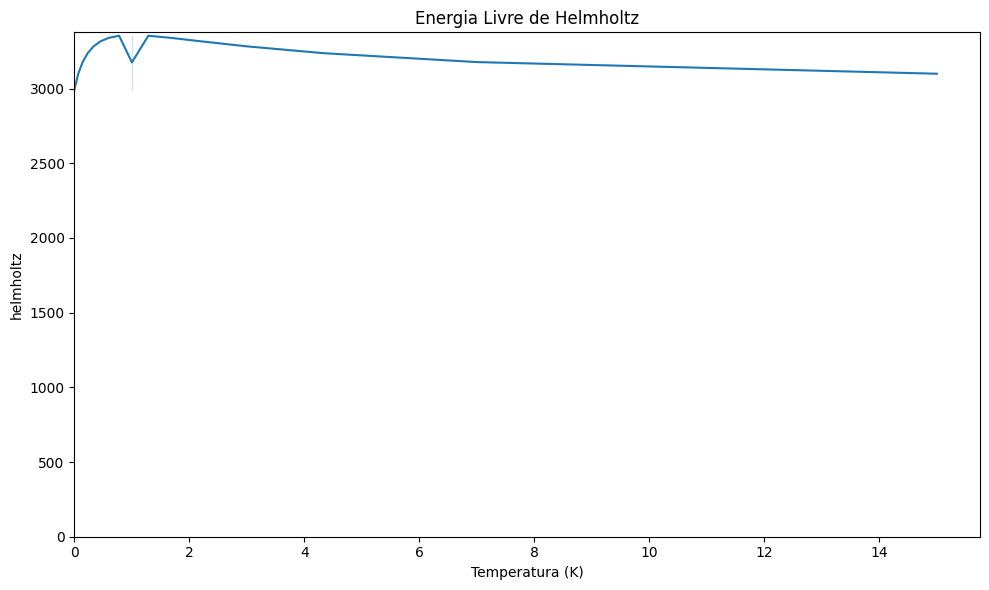

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=N_A_B_ratio, y=en)
plt.xlim(0, None)
plt.ylim(0, None)
sns.color_palette("Paired")
plt.title('Energia Livre de Helmholtz')
plt.xlabel('Temperatura (K)')
plt.ylabel('helmholtz')
plt.tight_layout()
# fig.get_figure() #'pega' o gráfico para salvar
# fig.savefig("helmholtz.pdf") #salva o gráfico 

### Playground

In [ ]:
def analise(size, N_a_range, temperatura):
    energia_matrix_list = []
    energia_helmholtz_list = []
    energia_config = []
    
    for N_a in N_a_range:
        print(N_a)
        N_b = (size*size) - N_a
        matrices = possible_matrices(size,N_a,N_b)
        for matrix in matrices:
            #vizinhos = determinar_vizinhos(matrix)
            energia_matrix = energia_total(matrix, E_AB, E_AA, E_BB, E_on_site)
            energia_matrix_list.append(energia_matrix)
        energia_helmholtz = helmholtz(energia_matrix_list,temperatura)
        energia_helmholtz_list.append(energia_helmholtz)
        energia_config.append(sum(energia_helmholtz_list))
        energia_matrix_list = []
        energia_helmholtz_list = []

    print(energia_config)


    return energia_config, len(energia_config)

In [ ]:
N_A_range = np.array([n for n in np.arange(0,size*size+step,step)]) # 1 A size**2
N_B_range = N_A_range[::-1]
N_A_B_ratio = N_A_range / N_B_range
N_A_B_ratio = np.where(np.isinf(N_A_B_ratio), 1, N_A_B_ratio)
print(N_A_B_ratio)

In [ ]:
size = SIZE
step = STEP
print(STEP)

N_A_range = np.array([n for n in np.arange(0,size*size+step,step)]) # 1 A size**2
print(N_A_range)
N_B_range = N_A_range[::-1]
N_A_B_ratio = N_A_range / N_B_range
N_A_B_ratio = np.where(np.isinf(N_A_B_ratio), 1, N_A_B_ratio)
print(N_A_B_ratio)


1
[0 1 2 3 4 5 6 7 8 9]
[0.         0.125      0.28571429 0.5        0.8        1.25
 2.         3.5        8.         1.        ]


C:\Users\gustavo220061\AppData\Local\Temp\ipykernel_21928\2932245074.py:8: RuntimeWarning: divide by zero encountered in divide
  N_A_B_ratio = N_A_range / N_B_range


In [ ]:
lst = [-10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2]
helmholtz(lst, 270.1)

18947.169590983623

In [ ]:
def calcular_vizinhos_v1(matriz):
    linhas, colunas = matriz.shape
    vizinhos = {}

    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    indices = itertools.product(range(linhas), range(colunas))

    for i, j in indices:
        vizinhos[(i, j)] = []

        # Calculate indices of neighboring elements
        neighbor_indices = (np.array([i, j]) + offsets) % np.array([linhas, colunas])

        # Add neighbors to the current element
        for ni, nj in neighbor_indices:
            vizinhos[(i, j)].append(matriz[ni, nj])

    return vizinhos

# Example usage
matriz = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])
vizinhos = calcular_vizinhos_v1(matriz)
print(vizinhos)


{(0, 0): [2, 4, 3, 7], (0, 1): [3, 5, 1, 8], (0, 2): [1, 6, 2, 9], (1, 0): [5, 7, 6, 1], (1, 1): [6, 8, 4, 2], (1, 2): [4, 9, 5, 3], (2, 0): [8, 1, 9, 4], (2, 1): [9, 2, 7, 5], (2, 2): [7, 3, 8, 6]}


In [ ]:
import numpy as np

def determinar_vizinhos_v2(matrix, size):
    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    i, j = np.indices((size, size))

    # Reshape offsets to have an extra dimension for broadcasting
    reshaped_offsets = offsets.reshape(1, 1, -1, 2)

    # Calculate indices of neighboring elements
    neighbor_indices = (i[..., np.newaxis, np.newaxis] + reshaped_offsets) % np.array([size, size])

    # Create a dictionary to store neighbors
    vizinhos = {(x, y): [matrix[neighbor_indices[x, y, k, 0]][neighbor_indices[x, y, k, 1]] for k in range(neighbor_indices.shape[2])] for x in range(size) for y in range(size)}

    return vizinhos

matriz_teste = [['AA', 'AB', 'BB'], ['AB', 'BB', 'BB'], ['BB', 'BB', 'BB']]
determiar_vizinho = determinar_vizinhos_v2(matriz_teste, 3)
print(determiar_vizinho)


{(0, 0): ['AB', 'AB', 'BB', 'BB'], (0, 1): ['AB', 'AB', 'BB', 'BB'], (0, 2): ['AB', 'AB', 'BB', 'BB'], (1, 0): ['BB', 'BB', 'AB', 'AB'], (1, 1): ['BB', 'BB', 'AB', 'AB'], (1, 2): ['BB', 'BB', 'AB', 'AB'], (2, 0): ['BB', 'BB', 'BB', 'BB'], (2, 1): ['BB', 'BB', 'BB', 'BB'], (2, 2): ['BB', 'BB', 'BB', 'BB']}


In [ ]:
import numpy as np
import itertools

def possible_matrices(N_A, N_B, n):
    total = N_A + N_B
    
    # Generate all possible combinations of indices for 'A's
    all_indices_A = list(itertools.combinations(range(n*n), N_A))
    
    # Generate matrices with 'B's filled in all cells
    matrices_B = np.full((len(all_indices_A), n, n), 'B', dtype='<U1')
    
    # Iterate through all possible combinations of indices for 'A's
    for i, indices in enumerate(all_indices_A):
        # Fill 'A's at specified indices
        indices = np.unravel_index(indices, (n, n))
        matrices_B[i][indices] = 'A'
    
    print(len(matrices_B))
    return matrices_B

# Example usage:
N_A = 3
N_B = 6
n = 3
result = possible_matrices(N_A, N_B, n)

# Printing the matrices
for matrix in result:
    print(matrix)
    print()


84
[['A' 'A' 'A']
 ['B' 'B' 'B']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['A' 'B' 'B']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'A' 'B']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'A']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'B']
 ['A' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'B']
 ['B' 'A' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'B']
 ['B' 'B' 'A']]

[['A' 'B' 'A']
 ['A' 'B' 'B']
 ['B' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'A' 'B']
 ['B' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'A']
 ['B' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'B']
 ['A' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'B']
 ['B' 'A' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'B']
 ['B' 'B' 'A']]

[['A' 'B' 'B']
 ['A' 'A' 'B']
 ['B' 'B' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'A']
 ['B' 'B' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'B']
 ['A' 'B' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'B']
 ['B' 'A' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'B']
 ['B' 'B' 'A']]

[['A' 'B' 'B']
 ['B' 'A' 'A']
 ['B' 'B' 'B']]

[['A' 'B' 'B']
 ['B' 'A' 'B']
 ['A' 'B' 'B']]

[['A' 'B' 'B']
 ['B' 'A' 'B']
 ['B' 'A' 'B']]

[['A' 'B' 